# Brain Tumor Classification

A brain tumor is considered one of the more dangerous diseases that could affect adults and children. The best technique to detect brain tumors is magnetic resonance imaging (MRI). Analysis of MRI is a complex task because factors such as location and size define whether we have a tumor and what kind of tumor. Professional neurosurgeon, the images that we are going to use in the project. The MRIs of this project are classified into four groups: glioma tumor, meningioma tumor, no tumor, and pituitary tumor. The objective of this job is to develop a convolutional neural network (CNN) that classifies an MRI with the right kind of tumor.

https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri/data

In [3]:
import kagglehub
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
from random import randrange
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,  GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from tensorflow.keras.optimizers import AdamW, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model


/opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data

The dataset was obtained from the [Brain Tumor Classification kaggle (MRI)](https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri/data) [1]. The dataset contains 3264 jpg images of Magnetic Resonance Imaging (MRI). The images are stored in two folders: Testing and Training. Each folder contains four subfolders that the name represents the MRI category.

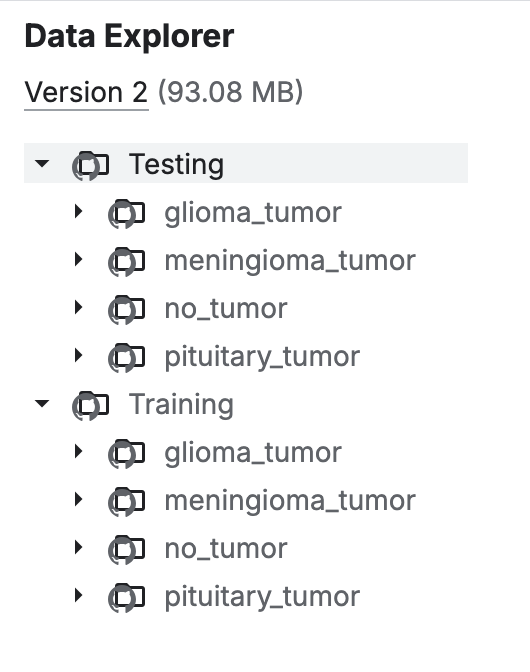

[1] Bhuvaji, S. (n.d.). Brain tumor classification (MRI) [Dataset]. Kaggle. Retrieved February 27, 2025, from https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri/




In [4]:
path = kagglehub.dataset_download("sartajbhuvaji/brain-tumor-classification-mri")

print("Path to dataset files:", path)

100%|██████████████████████████████████████| 86.8M/86.8M [00:06<00:00, 14.5MB/s]

Extracting files...


Path to dataset files: /Users/jorgevergara/.cache/kagglehub/datasets/sartajbhuvaji/brain-tumor-classification-mri/versions/2


### Exploratory Data Analysis (EDA)

In [5]:
labels = ["no_tumor", "glioma_tumor", "meningioma_tumor", "pituitary_tumor"]

data = []

for label in labels:
  full_path = os.path.join(path, "Training", label)
  for img_name in os.listdir(full_path):
    data.append([os.path.join(full_path, img_name), label])

df = pd.DataFrame(data, columns=["path", "label"])
df.head()


,path,label
0,/Users/jorgevergara/.cache/kagglehub/datasets/...,no_tumor
1,/Users/jorgevergara/.cache/kagglehub/datasets/...,no_tumor
2,/Users/jorgevergara/.cache/kagglehub/datasets/...,no_tumor
3,/Users/jorgevergara/.cache/kagglehub/datasets/...,no_tumor
4,/Users/jorgevergara/.cache/kagglehub/datasets/...,no_tumor


In [ ]:
df['label'].value_counts()

,count
label,
pituitary_tumor,827
glioma_tumor,826
meningioma_tumor,822
no_tumor,395


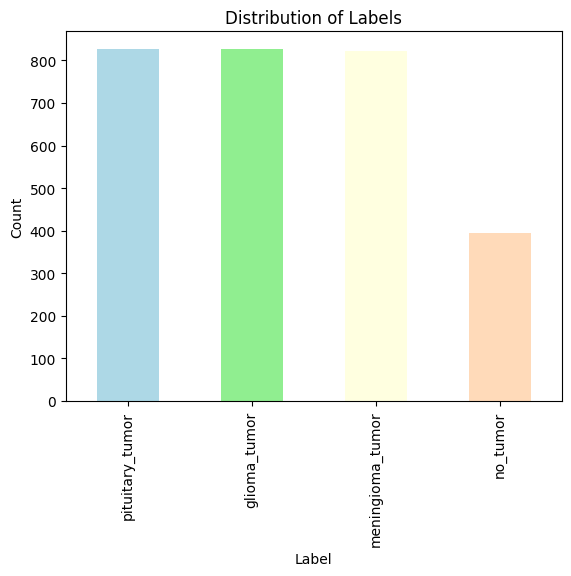

In [ ]:
ax = df['label'].value_counts().plot(kind='bar', color=['lightblue', 'lightgreen','lightyellow', 'peachpuff' ])

plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

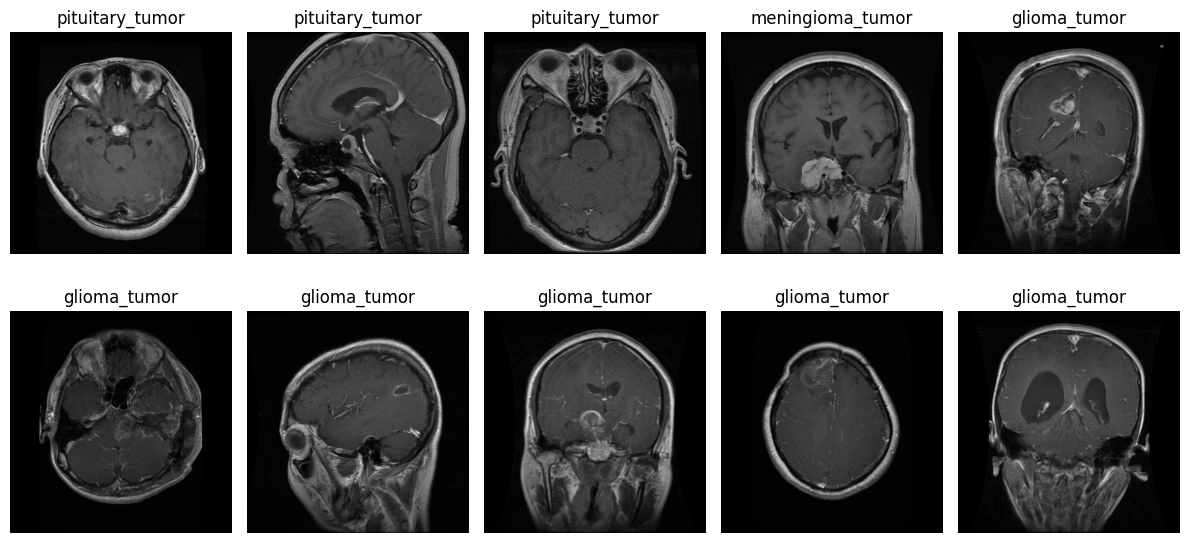

In [ ]:
num_samples = 10

fig, axes = plt.subplots(2, num_samples//2, figsize=(12, 6))
sample_images = df.sample(num_samples).reset_index(drop=True)

for i, ax in enumerate(axes.flat):
    img_path = sample_images.loc[i, 'path']
    img = Image.open(img_path)
    ax.imshow(img, cmap="gray")
    ax.set_title(f"{sample_images.loc[i, 'label']}")

    ax.axis("off")

plt.tight_layout()
plt.show()

<Figure size 800x400 with 0 Axes>

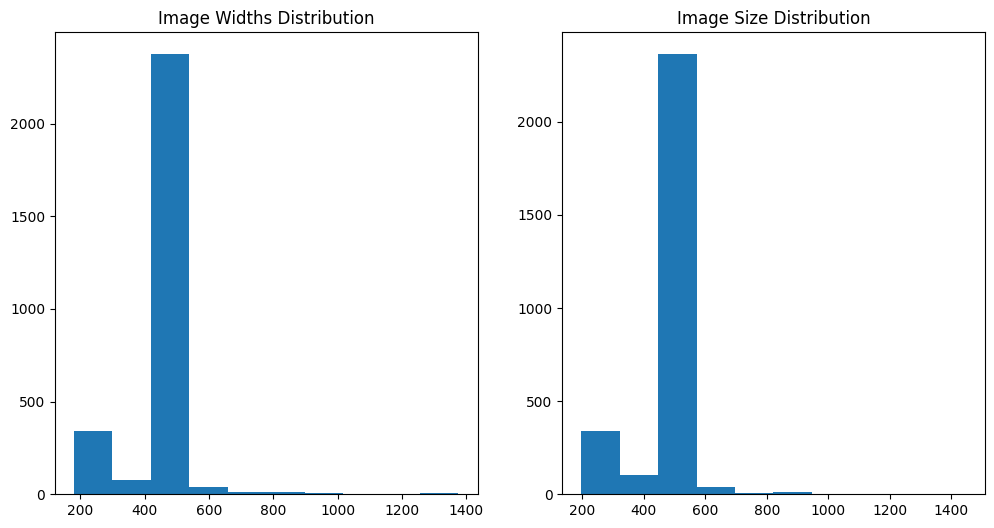

In [ ]:

image_shapes = [Image.open(img).size for img in df['path']]
widths, heights = zip(*image_shapes)

plt.figure(figsize=(8, 4))

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].hist(widths)
axes[0].set_title(f"Image Widths Distribution")

axes[1].hist(heights)
axes[1].set_title(f"Image Heights Distribution")

plt.title("Image Size Distribution")
plt.show()

The images have different with and height.

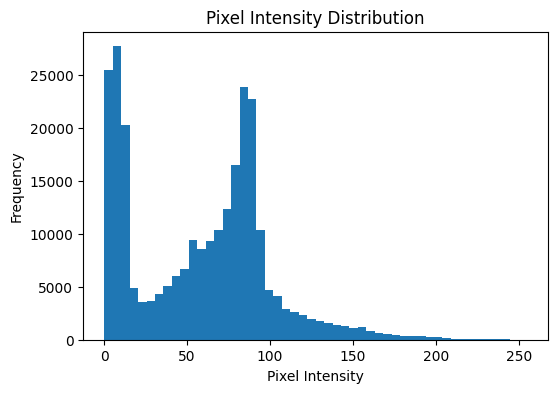

In [ ]:
randon_image = df.iloc[randrange(df.shape[0])]['path']
img = cv2.imread(randon_image, cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(6, 4))
plt.hist(img.ravel(), bins=50)
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.show()

### DModel Architecture

First, we are going to read all the images that are stored in the folder `/Training`. These images are going to be resized to 256x256 and use 80% as the training set and 20% as the validation set.

In [6]:
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 32

dataset_path = os.path.join(path, "Training")

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training"
)


val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation"
)

print("Classes found:", train_generator.class_indices)

Found 2297 images belonging to 4 classes.
Found 573 images belonging to 4 classes.
Classes found: {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


In [7]:
testing_dataset_path = os.path.join(path, "Testing")

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    testing_dataset_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

Found 394 images belonging to 4 classes.


Now, we are going to define our first model. The model is a CNN that contains a feature extractor with 3 layers applying 2D convolution, a ReLU activation function, and 2D max pooling. The classification part has two layers, the first with 128 neurons with ReLU as the activation function and the output layer with 4 neurons with a softmax activation function that is the best choise for multi class classification.

In [8]:
num_classes = len(train_generator.class_indices)

In [ ]:
model = Sequential([
    Conv2D(32, (3,3), activation="relu", input_shape=(256, 256, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation="relu"),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation="relu"),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation="relu"),
    Dense(num_classes, activation="softmax")
])

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      14,745,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,839,492 (56.61 MB)

 Trainable params: 14,839,492 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
def plot_acc_and_loss(metrics):
    acc = metrics.history['accuracy']
    val_acc = metrics.history['val_accuracy']
    loss = metrics.history['loss']
    val_loss = metrics.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training ACC')
    plt.plot(epochs_range, val_acc, label='Validation ACC')
    plt.xlabel('Epochs')
    plt.ylabel('ACC')
    plt.legend()
    plt.title('Training and Validation ACC')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.show()


In [9]:
def get_true_and_predicted_classes(my_model):
  predictions = my_model.predict(test_generator)
  predicted_classes = np.argmax(predictions, axis=1)

  true_classes = test_generator.classes
  class_labels = list(test_generator.class_indices.keys())

  return (true_classes, predicted_classes, class_labels)

def plot_confusion_matrix(title, true_classes, predicted_classes, class_labels):
  cm = confusion_matrix(true_classes, predicted_classes)

  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.title(title)
  plt.show()

def compute_metrics(true_classes, predicted_classes, class_labels):
  accuracy = accuracy_score(true_classes, predicted_classes)
  print(f"Accuracy: {accuracy:.4f}")

  precision = precision_score(true_classes, predicted_classes, average='weighted')
  print(f"Precision: {precision:.4f}")

  recall = recall_score(true_classes, predicted_classes, average='weighted')
  print(f"Recall: {recall:.4f}")

  print("\nClassification Report:\n")
  print(classification_report(true_classes, predicted_classes, target_names=class_labels))

In [ ]:
EPOCHS = 20

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 51s 616ms/step - accuracy: 0.3561 - loss: 1.4811 - val_accuracy: 0.3717 - val_loss: 1.2722
Epoch 2/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 39s 548ms/step - accuracy: 0.4928 - loss: 1.1504 - val_accuracy: 0.4555 - val_loss: 1.1353
Epoch 3/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 39s 547ms/step - accuracy: 0.5535 - loss: 1.0351 - val_accuracy: 0.4468 - val_loss: 1.1330
Epoch 4/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 39s 549ms/step - accuracy: 0.6060 - loss: 0.9219 - val_accuracy: 0.4939 - val_loss: 1.2422
Epoch 5/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 39s 545ms/step - accuracy: 0.6307 - loss: 0.8859 - val_accuracy: 0.4066 - val_loss: 1.1771
Epoch 6/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 39s 547ms/step - accuracy: 0.6526 - loss: 0.8205 - val_accuracy: 0.5131 - val_loss: 1.0180
Epoch 7/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 39s 545ms/step - accuracy: 0.6639 - loss: 0.8001 - val_accuracy: 0.5131 - val_loss: 1.1079
Epoch 8/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 40s 551ms/step - accuracy: 0.6683 - loss: 0.7887 - val_accu

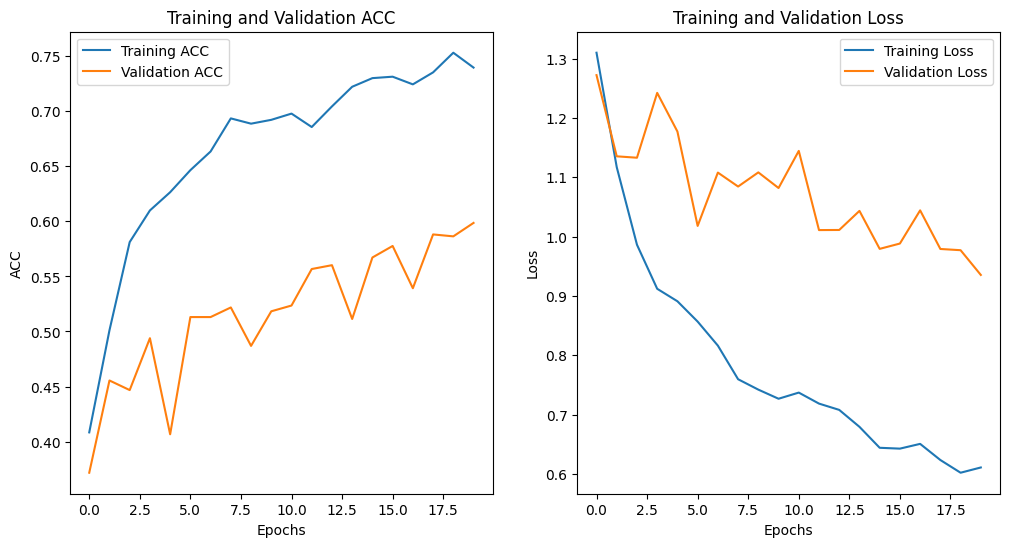

In [ ]:
plot_acc_and_loss(history)

In [ ]:
(y_true, y_pred, classes) = get_true_and_predicted_classes(model)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


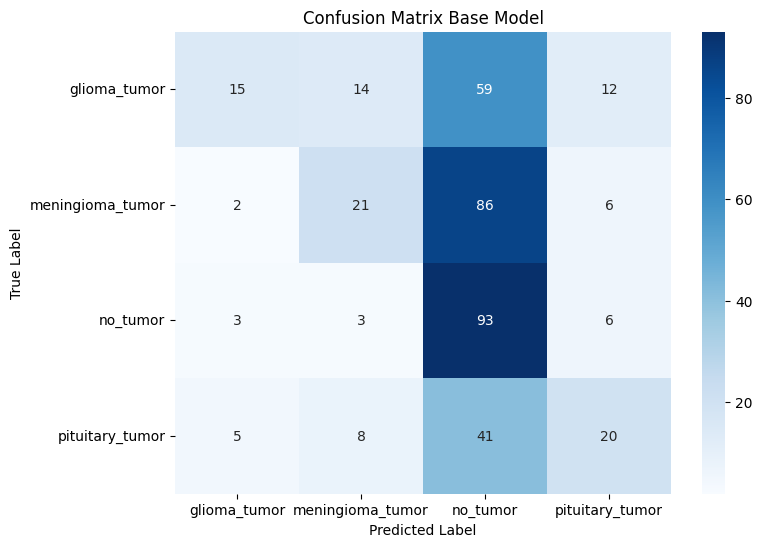

In [ ]:
plot_confusion_matrix("Confusion Matrix Base Model", y_true, y_pred, classes)

In [ ]:
compute_metrics(y_true, y_pred, classes)

Accuracy: 0.3782
Precision: 0.4597
Recall: 0.3782

Classification Report:

                  precision    recall  f1-score   support

    glioma_tumor       0.60      0.15      0.24       100
meningioma_tumor       0.46      0.18      0.26       115
        no_tumor       0.33      0.89      0.48       105
 pituitary_tumor       0.45      0.27      0.34        74

        accuracy                           0.38       394
       macro avg       0.46      0.37      0.33       394
    weighted avg       0.46      0.38      0.33       394



### Tuning model

Now, we are going to apply some techniques to improve the model performance. First, we are going to add a dropout of 50% in the dense classification layer in order to avoid overfitting. Second, use an AdamW optimizer that decouples weight decay from gradient updates for better generalization. Third, increase the epoch number to increase the accuracy. And last, use early stopping to stop the training at the best performance and avoid overfitting.

In [ ]:
model_2= Sequential([
    Conv2D(32, (3,3), activation="relu", input_shape=(256, 256, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation="relu"),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation="relu"),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

optimizer = AdamW(learning_rate=0.001, weight_decay=1e-5)

model_2.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy"])

model_2.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)                   │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │      14,745,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,839,492 (56.61 MB)

 Trainable params: 14,839,492 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

EPOCHS = 50

history_2 = model_2.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[early_stopping]
)

Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 42s 585ms/step - accuracy: 0.4231 - loss: 1.2440 - val_accuracy: 0.3159 - val_loss: 1.2459
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 40s 553ms/step - accuracy: 0.4535 - loss: 1.1649 - val_accuracy: 0.4276 - val_loss: 1.1912
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 40s 550ms/step - accuracy: 0.4986 - loss: 1.1088 - val_accuracy: 0.4555 - val_loss: 1.1612
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 40s 550ms/step - accuracy: 0.5527 - loss: 1.0235 - val_accuracy: 0.3647 - val_loss: 1.1542
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 39s 549ms/step - accuracy: 0.5745 - loss: 0.9834 - val_accuracy: 0.4136 - val_loss: 1.0947
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 39s 545ms/step - accuracy: 0.5661 - loss: 0.9521 - val_accuracy: 0.4066 - val_loss: 1.1360
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 40s 551ms/step - accuracy: 0.6067 - loss: 0.9434 - val_accuracy: 0.5271 - val_loss: 1.0616
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 39s 546ms/step - accuracy: 0.6089 - loss: 0.9277 - val_accu

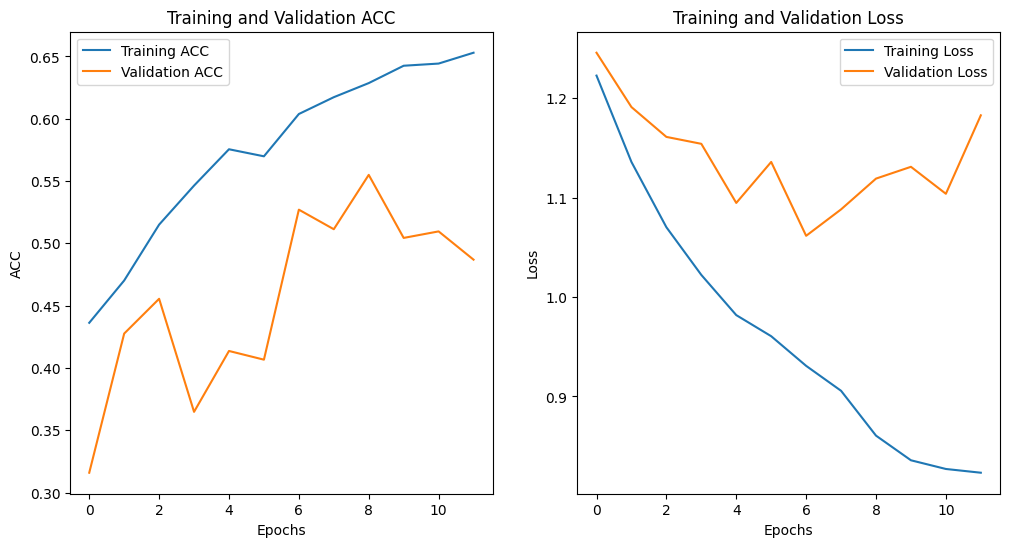

In [ ]:
plot_acc_and_loss(history_2)

In [ ]:
(y_true, y_pred, classes) = get_true_and_predicted_classes(model_2)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step


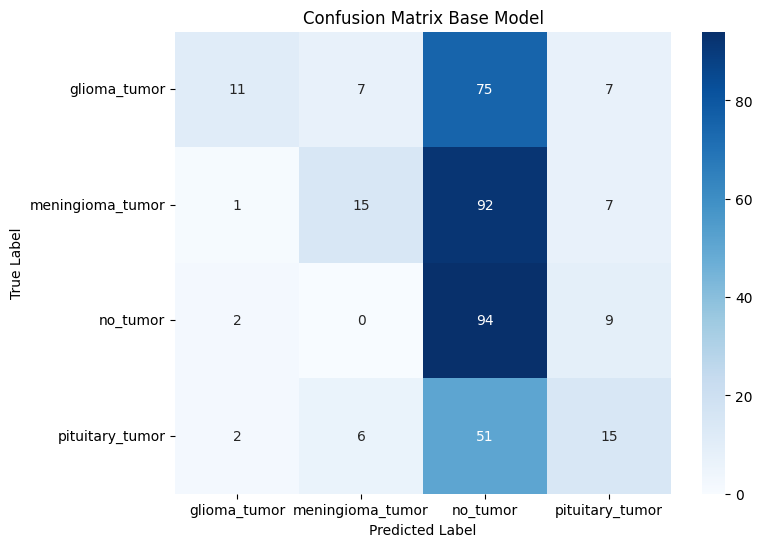

In [ ]:
plot_confusion_matrix("Confusion Matrix Base Model", y_true, y_pred, classes)

In [ ]:
compute_metrics(y_true, y_pred, classes)

Accuracy: 0.3426
Precision: 0.4853
Recall: 0.3426

Classification Report:

                  precision    recall  f1-score   support

    glioma_tumor       0.69      0.11      0.19       100
meningioma_tumor       0.54      0.13      0.21       115
        no_tumor       0.30      0.90      0.45       105
 pituitary_tumor       0.39      0.20      0.27        74

        accuracy                           0.34       394
       macro avg       0.48      0.33      0.28       394
    weighted avg       0.49      0.34      0.28       394



In this step, we are going to transfer learning techniques. Using the pre-training model InceptionV3. That is good for multi-class MRI and detecting complex patterns.

In [ ]:
base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=(256, 256, 3))

base_model.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation="softmax")(x)


model_3 = Model(inputs=base_model.input, outputs=output)

optimizer = AdamW(learning_rate=0.001, weight_decay=1e-5)

model_3.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

model_3.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_298 (Conv2D)       │ (None, 127, 127, 32)   │            864 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_282   │ (None, 127, 127, 32)   │             96 │ conv2d_298[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_282            │ (None, 127, 127, 32)   │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_299 (Conv2D)       │ (None, 125, 125, 32)   │          9,216 │ activation_282[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_283   │ (None, 125, 125, 32)   │             96 │ conv2d_299[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_283            │ (None, 125, 125, 32)   │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_300 (Conv2D)       │ (None, 125, 125, 64)   │         18,432 │ activation_283[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_284   │ (None, 125, 125, 64)   │            192 │ conv2d_300[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_284            │ (None, 125, 125, 64)   │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_28          │ (None, 62, 62, 64)     │              0 │ activation_284[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_301 (Conv2D)       │ (None, 62, 62, 80)     │          5,120 │ max_pooling2d_28[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_285   │ (None, 62, 62, 80)     │            240 │ conv2d_301[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_285            │ (None, 62, 62, 80)     │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_302 (Conv2D)  

 Total params: 31,240,612 (119.17 MB)

 Trainable params: 9,437,828 (36.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

EPOCHS = 50

history_3 = model_3.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[early_stopping]
)

Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 72s 798ms/step - accuracy: 0.4122 - loss: 8.8842 - val_accuracy: 0.4276 - val_loss: 1.2300
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 40s 550ms/step - accuracy: 0.4808 - loss: 1.1264 - val_accuracy: 0.6213 - val_loss: 0.8633
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 39s 548ms/step - accuracy: 0.5107 - loss: 1.0698 - val_accuracy: 0.6108 - val_loss: 0.9920
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 39s 546ms/step - accuracy: 0.5262 - loss: 1.0227 - val_accuracy: 0.6178 - val_loss: 0.9281
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 40s 551ms/step - accuracy: 0.5573 - loss: 1.0178 - val_accuracy: 0.7138 - val_loss: 0.8256
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 39s 548ms/step - accuracy: 0.5891 - loss: 0.9610 - val_accuracy: 0.6928 - val_loss: 0.8496
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 39s 547ms/step - accuracy: 0.6230 - loss: 0.9140 - val_accuracy: 0.6440 - val_loss: 0.8591
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 39s 547ms/step - accuracy: 0.5560 - loss: 1.0095 - val_accu

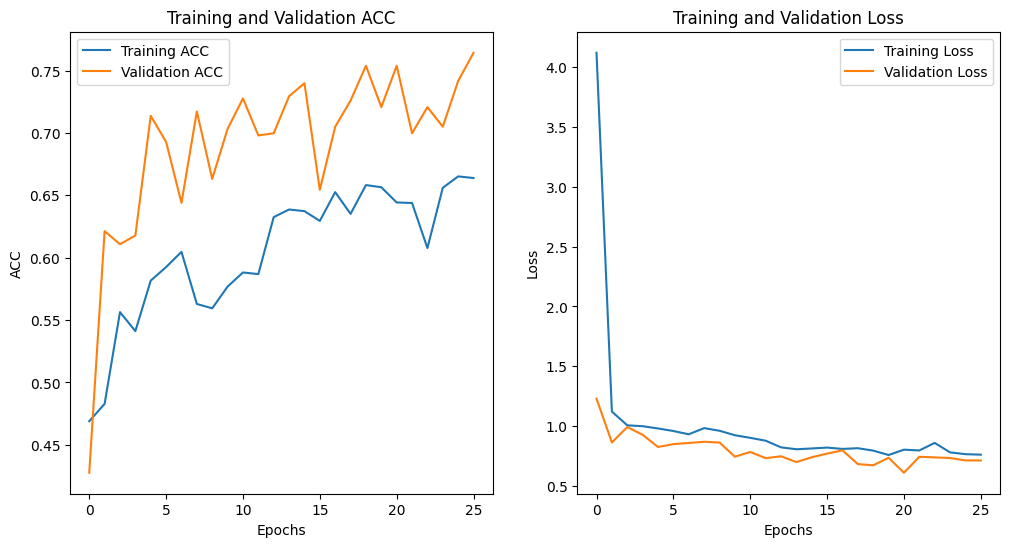

In [ ]:
plot_acc_and_loss(history_3)

In [ ]:
(y_true, y_pred, classes) = get_true_and_predicted_classes(model_3)

13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 654ms/step


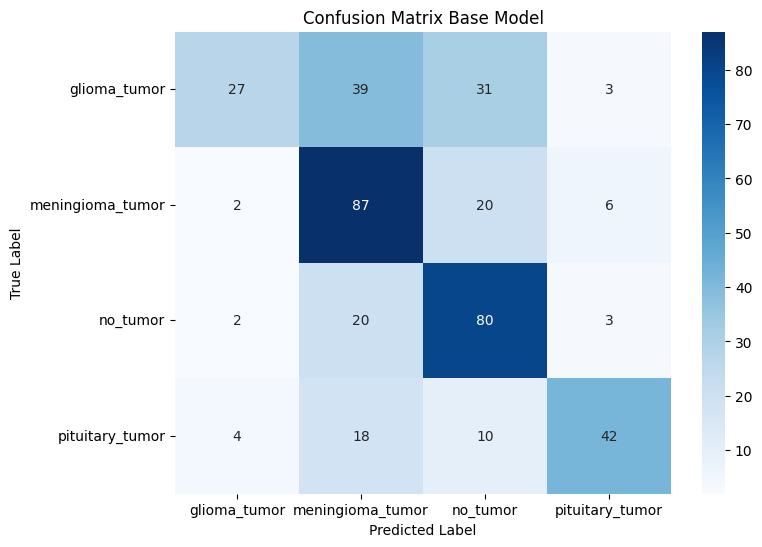

In [ ]:
plot_confusion_matrix("Confusion Matrix Base Model", y_true, y_pred, classes)

In [ ]:
compute_metrics(y_true, y_pred, classes)

Accuracy: 0.5990
Precision: 0.6479
Recall: 0.5990

Classification Report:

                  precision    recall  f1-score   support

    glioma_tumor       0.77      0.27      0.40       100
meningioma_tumor       0.53      0.76      0.62       115
        no_tumor       0.57      0.76      0.65       105
 pituitary_tumor       0.78      0.57      0.66        74

        accuracy                           0.60       394
       macro avg       0.66      0.59      0.58       394
    weighted avg       0.65      0.60      0.58       394



In this approach, we are going to continue with transfer learning with the InceptionV3 model. First, we are going to allow training in the last 30 layers of the InceptionV3 model. Then, reducing the dropout to 30% to be less severe. Using GlobalAveragePooling instead of Flatten to reduce the parameters. Also, use the SGD optimizer with a 0.01 learning rate and a momentum of 0.9 for a better generalization. And use a learning rate scheduler in order to change the learning rate based on the loss function to get better training.

In [11]:
base_model_2 = InceptionV3(weights="imagenet", include_top=False, input_shape=(256, 256, 3))

for layer in base_model_2.layers[:-30]:
    layer.trainable = False
for layer in base_model_2.layers[-30:]:
    layer.trainable = True

x = base_model_2.output
x = GlobalAveragePooling2D()(x)
x = Dense(256)(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.3)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation="softmax")(x)

model_4 = Model(inputs=base_model_2.input, outputs=output)

optimizer = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)

model_4.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

model_4.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


/opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 127, 127,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 127, 127,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 127, 127,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 125, 125,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 125, 125,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 125, 125,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 125, 125,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 125, 125,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 125, 125,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 62, 62,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 62, 62,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 62, 62,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 62, 62,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 60, 60,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 60,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 60, 60,    │          0 │ batch_normalizat

 Total params: 22,360,740 (85.30 MB)

 Trainable params: 5,713,988 (21.80 MB)

 Non-trainable params: 16,646,752 (63.50 MB)

In [13]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

EPOCHS = 50

history_4 = model_4.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.7013 - loss: 0.7476 - val_accuracy: 0.6178 - val_loss: 1.2679 - learning_rate: 0.0100
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.8344 - loss: 0.4377 - val_accuracy: 0.8394 - val_loss: 0.4619 - learning_rate: 0.0100
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.8727 - loss: 0.3416 - val_accuracy: 0.7627 - val_loss: 0.6828 - learning_rate: 0.0100
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 72s 997ms/step - accuracy: 0.8985 - loss: 0.2630 - val_accuracy: 0.8115 - val_loss: 0.5165 - learning_rate: 0.0100
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 811ms/step - accuracy: 0.9050 - loss: 0.2418
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
72/72 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.9051 - loss: 0.2417 - val_accuracy: 0.7993 - val_loss: 0.6347 - learning_rate: 0.0100
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.9232 - loss: 0.2143 - val_accurac

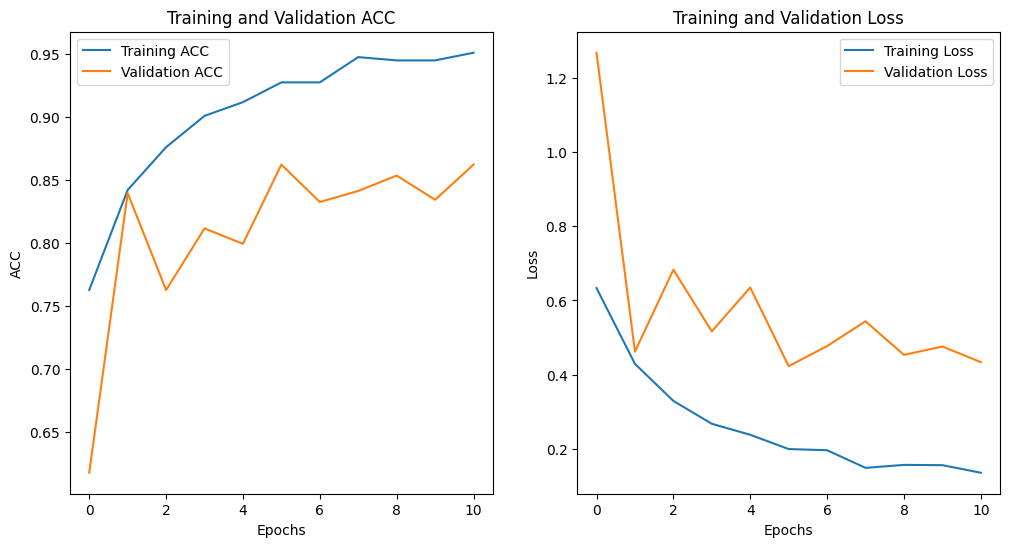

In [20]:
plot_acc_and_loss(history_4)

In [14]:
(y_true, y_pred, classes) = get_true_and_predicted_classes(model_4)

13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 727ms/step


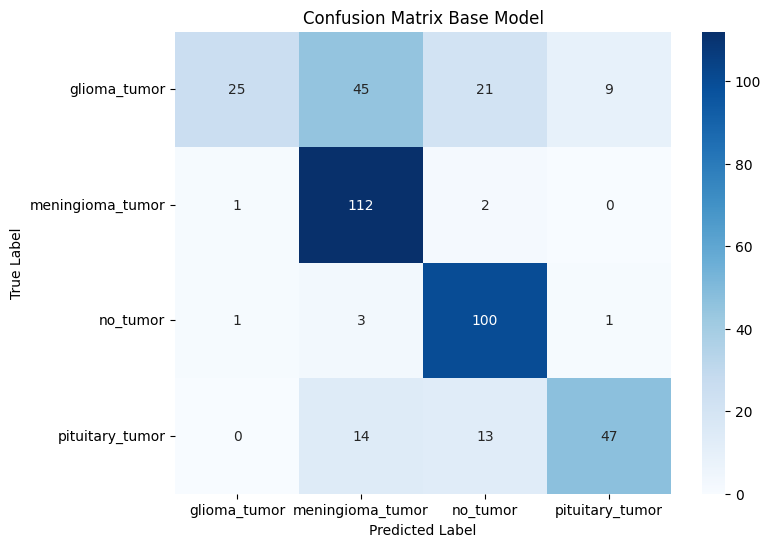

In [15]:
plot_confusion_matrix("Confusion Matrix Base Model", y_true, y_pred, classes)

In [16]:
compute_metrics(y_true, y_pred, classes)

Accuracy: 0.7208
Precision: 0.7737
Recall: 0.7208

Classification Report:

                  precision    recall  f1-score   support

    glioma_tumor       0.93      0.25      0.39       100
meningioma_tumor       0.64      0.97      0.78       115
        no_tumor       0.74      0.95      0.83       105
 pituitary_tumor       0.82      0.64      0.72        74

        accuracy                           0.72       394
       macro avg       0.78      0.70      0.68       394
    weighted avg       0.77      0.72      0.68       394



### Conclutions

- The model 1 is a simple CNN that applies 3 convolutions in the feature extractor layer and has 2 layers for classification. This model gets a validation accuracy of 0.56. The performance in the test data was very poorly, getting 0.37 accuracy. This is an overfitting signal. In the confusion matrix, we can validate that a high number of images are predicted as the no tumor category. This should be a signal of poor performance in the feature extractor layer.

- The model 2, We increase the number of epochs, adding a dropout of 0.5 to avoid overfitting and changing the optimizer. The validation accuracy was 0.48 and the test accuracy was 0.34, both worse than model 1. The high number of images predicted, like the no tumor category, is still in the result.

- We suspect poor performance of the feature extraction layer. For that reason, for model 3, we use the transfer learning technique with the InceptionV3 model that proved good performance in RMI images in previous jobs. The result was a reduction in the overfitting in the model, getting a greater validation accuracy against training accuracy. The validation accuracy was 0.76. Also, we can observe a better performance in the test accuracy, precision, and recall: 0.59 , 0.64 , and 0.59, respectively.

- For model 4, we apply the next changes. Train the last 30 layers of InceptionV3 to increase the effectiveness of the feature extractor in our dataset. Reduce the dropout to 0.3 to be less aggressive in the overfitting detection because we see no overfitting signal in model 3. Change the optimizer and use learning rate scheduling to improve the stability of the accuracy. Model 4 gets 0.86 of validation accuracy, the best performance of the models. Also, in the test set, we get an accuracy of 0.72, precision of 0.77, and recall of 0.72.

- For future works, we can tune the architecture of the neural network using different learning rates, try transfer learning with different models, and use different optimization functions.